In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.datasets
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import kelbow_visualizer

np.set_printoptions(precision=30)

# Functions

In [ ]:
def find_centroid(arr): # find centoid of data
    shape_of_arr = arr.shape
    np_of_sums = np.array([(np.sum(arr[:, i]) / shape_of_arr[0]) for i in range(shape_of_arr[1])])
    return np_of_sums

In [ ]:
def Mahalanobis(arr): # Mahalanobis depth function
  arr_centroid = find_centroid(arr)
  cov_inv = np.linalg.pinv(np.cov(np.transpose(arr)))
  return [1 / (1 + (arr[i, :] - arr_centroid).dot(cov_inv).dot(np.array([arr[i, :] - arr_centroid]).T)) for i in range(arr.shape[0])]

In [ ]:
def math_round(num):
    return int(num + (0.5 if num > 0 else -0.5))

In [ ]:
def original_function(X, return_val = False): # Estimating Number Of Clusters
  D = Mahalanobis(X)
  DM = max(D)
  delta = np.average(np.absolute(D - DM))
  result_df = pd.DataFrame({'clusterCount':[], 'DeD':[]})
  ans = 0
  for k in range(2, 30):
    range_ = X.shape[0] / k
    end = -1
    delta_k = []
    for j in range(1, k + 1):
      start = end + 1
      end = start + range_ - 1
      D_k = Mahalanobis(X[math_round(start) : math_round(end) + 1, :])
      DM_k = max(D_k)
      delta_k.append(np.average(np.absolute(D_k - DM_k)))
    DW = np.average(delta_k)
    DB = delta - DW
    DeD = DW - DB
    result_df = result_df.append({'clusterCount':k, 'DeD':DeD}, ignore_index=True)
  if return_val:
    return result_df.DeD.argmax() + 1
  else:
    plt.plot(result_df['clusterCount'], result_df['DeD'], linestyle='--', marker='o', color='b');
    plt.xlabel('K');
    plt.ylabel('DeD');
    plt.title('DeD vs. K')
    max_index = np.where(result_df['DeD'] == max(result_df['DeD']))
    ded_max = result_df.loc[max_index, 'DeD']
    k_max = result_df.loc[max_index, 'clusterCount']
    plt.annotate('max value', xy=(k_max, ded_max))  
    plt.show()

# Test of find_centroid 

In [ ]:
find_centroid(np.array([[0, 0], [10, 0], [10, 10], [0, 10]]))

array([5., 5.])

In [ ]:
find_centroid(np.array([[1, 1], [5, 5]]))

array([3., 3.])

# Test Mahalanobis

In [ ]:
iris = sklearn.datasets.load_iris()
X_iris = iris.data

Mahalanobis_for_iris = Mahalanobis(X_iris)

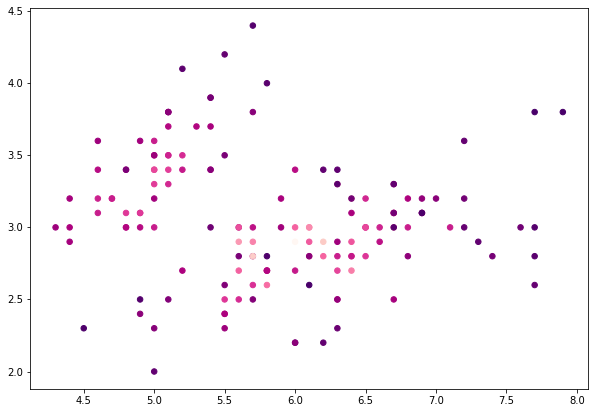

In [ ]:
dim_1 = X_iris[:, 0]
dim_2 = X_iris[:, 1]

# fig, ax = plt.subplots(figsize=(20, 20))
# ax.scatter(dim_1, dim_2)

# for i, txt in enumerate(Mahalanobis_for_iris):
#     ax.annotate(txt, (dim_1[i], dim_2[i]))

plt.figure(figsize=(10, 7))
plt.scatter(dim_1, dim_2, c = Mahalanobis_for_iris, cmap = 'RdPu_r', s = 30)

# Test original function

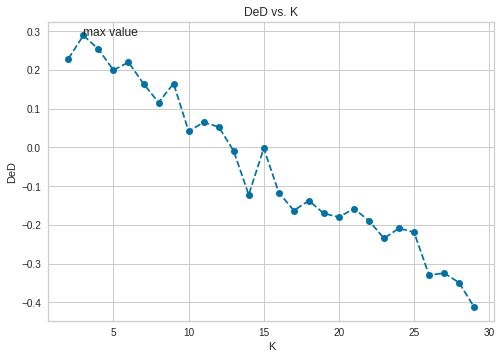

In [ ]:
original_function(X_iris)

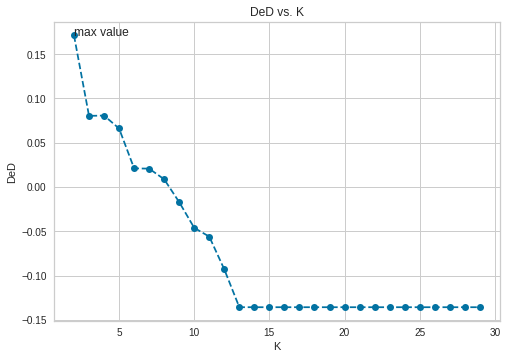

In [ ]:
wine = sklearn.datasets.load_wine()
original_function(wine.data)

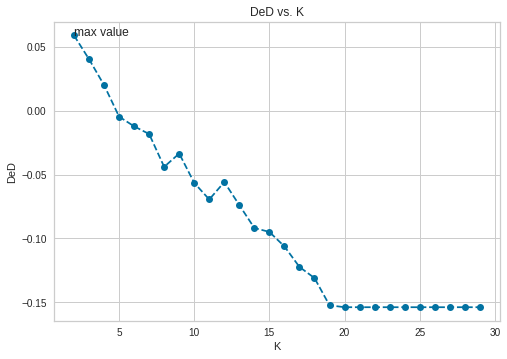

In [ ]:
breast_cancer = sklearn.datasets.load_breast_cancer()
original_function(breast_cancer.data)

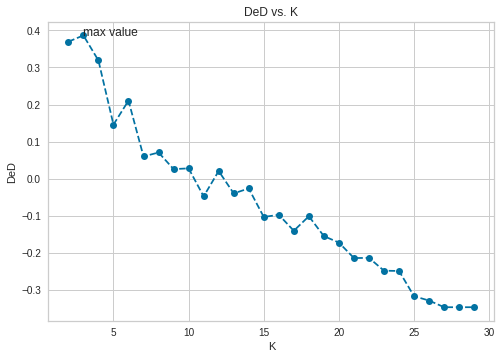

In [ ]:
# https://archive-beta.ics.uci.edu/ml/datasets/236
# Seed

seed = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt', sep="\t", header=None, names=list('abcdefghij')).fillna(0)
original_function(np.array(seed))

#  Индекс силуэта (2.3)

In [ ]:
def silhouette_score_visualisation(cluster_df, return_val = False):
  from yellowbrick.cluster import KElbowVisualizer
  model = KMeans()
  model.fit(cluster_df)
  visualizer = KElbowVisualizer(model, k=(2,30),metric='silhouette', timings= True)
  visualizer.fit(cluster_df)
  if return_val:
    return visualizer.elbow_value_
  visualizer.show()
  plt.show()

# Индекс зазора (2.4)

In [ ]:
def optimalK(data, return_val = False, nrefs=3, maxClusters=30):
    """
    Calculates KMeans optimal K using Gap Statistic 
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
    Returns: gap
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):
    # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)
        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp
        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_
        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)
        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

 #   std_val = np.std(np.array(resultsdf['gap']))
    ans = maxClusters - 1
    for j in range(maxClusters - 2):
      if resultsdf.loc[j, 'gap'] >= resultsdf.loc[j + 1, 'gap'] - np.std(np.array(resultsdf['gap'])[:j + 2]):
        ans = j
        break
    if return_val:
      return ans + 1

    plt.plot(resultsdf['clusterCount'], resultsdf['gap'], linestyle='--', marker='o', color='b')
    plt.xlabel('K')
    plt.ylabel('Gap Statistic')
    plt.title('Gap Statistic vs. K')
    
    gap_max = resultsdf.loc[ans, 'gap']
    plt.annotate('best value', xy=(ans, gap_max))  
    plt.show()

In [ ]:
optimalK(X_iris, True)

2

# Тестирование индексов


DeD:


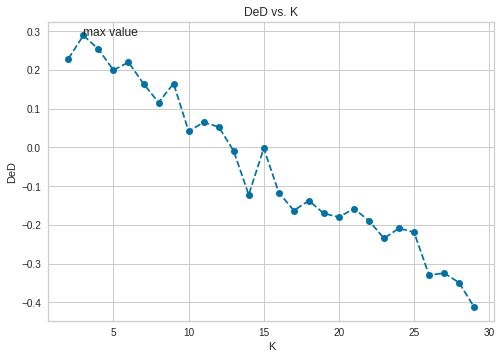

Silhouette Coefficient


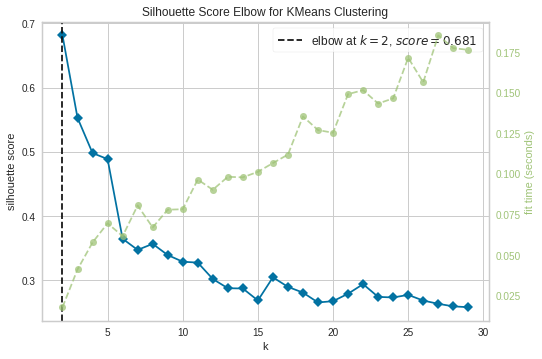

Gap Statistic


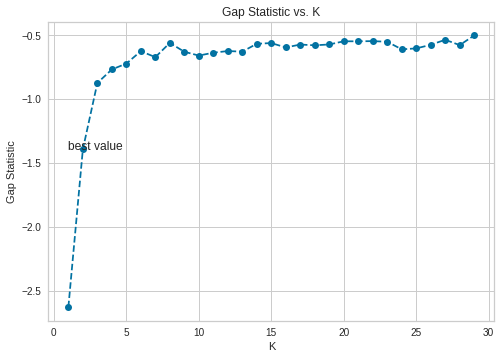

In [ ]:
print('DeD:')
original_function(X_iris)

print('Silhouette Coefficient')
silhouette_score_visualisation(X_iris)

print('Gap Statistic')
optimalK(X_iris)

DeD:


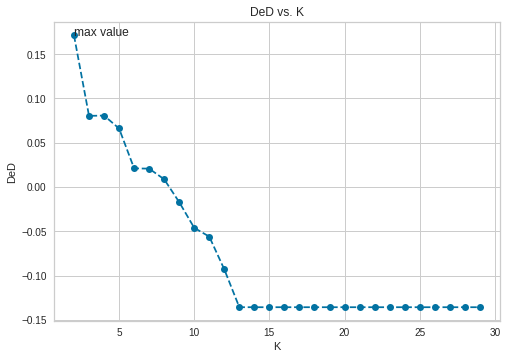

Silhouette Coefficient


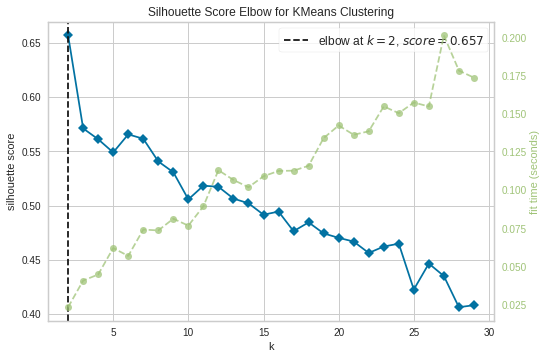

Gap Statistic


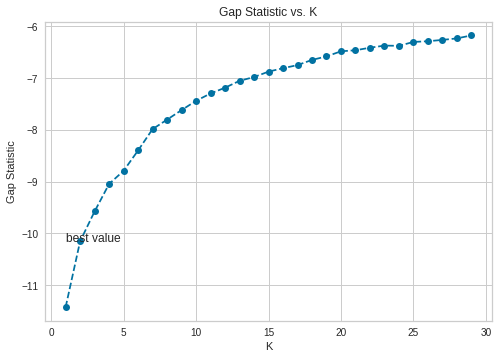

In [ ]:
print('DeD:')
original_function(wine.data)

print('Silhouette Coefficient')
silhouette_score_visualisation(wine.data)

print('Gap Statistic')
optimalK(wine.data)

DeD:


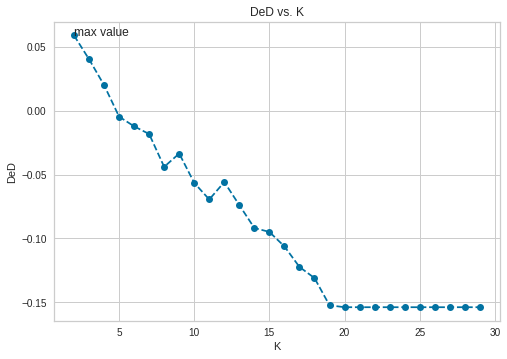

Silhouette Coefficient


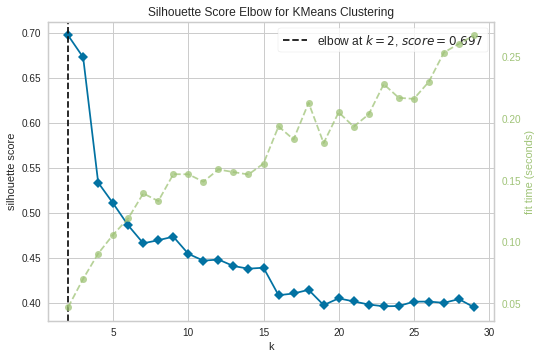

Gap Statistic


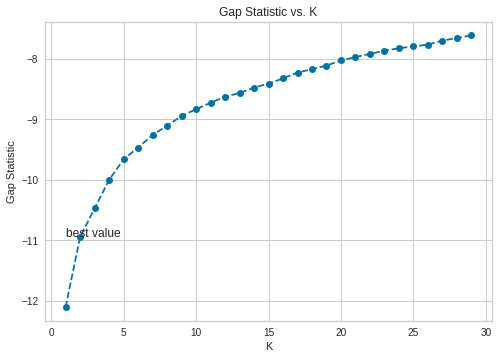

In [ ]:
print('DeD:')
original_function(breast_cancer.data)

print('Silhouette Coefficient')
silhouette_score_visualisation(breast_cancer.data)

print('Gap Statistic')
optimalK(breast_cancer.data)

DeD:


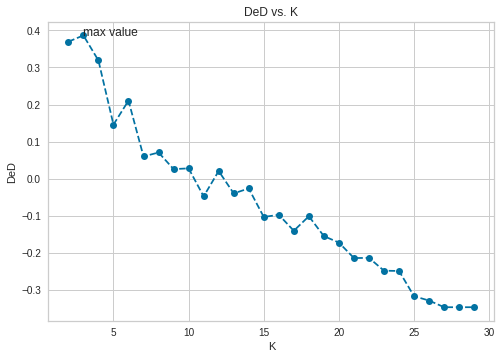

Silhouette Coefficient


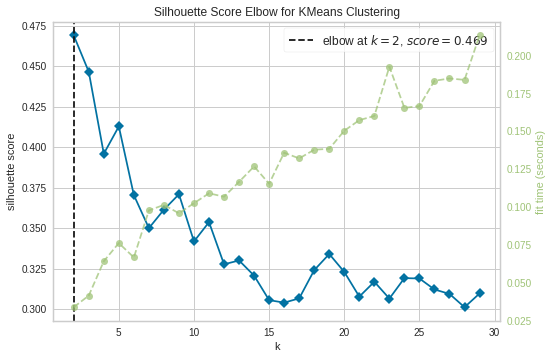

Gap Statistic


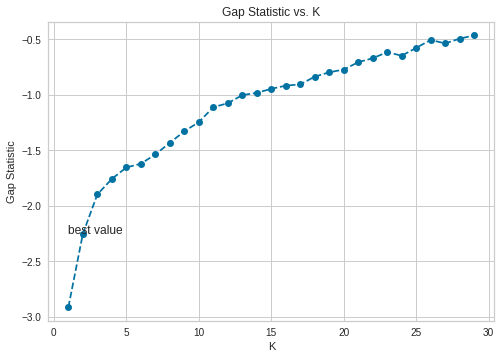

In [ ]:
print('DeD:')
original_function(np.array(seed))

print('Silhouette Coefficient')
silhouette_score_visualisation(np.array(seed))

print('Gap Statistic')
optimalK(np.array(seed))

# Генерация данных и эксперименты

In [ ]:
# 3000, 20, k = 15/25, а = 0.25 / 0.75, по 10 раз

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.metrics import adjusted_rand_score

def testing_generations(c, a, test_num):
  DeD_rel = list()
  sil_rel = list()
  gap_rel = list()
  DeD_ari = list()
  sil_ari = list()
  gap_ari = list()
  random_states = [i + test_num * 10 for i in range(10)]
  for i in range(10):
    X_, y_ = make_blobs(n_samples=3000, centers=c, n_features=20, cluster_std = a, random_state=random_states[i])

    DeD_val = original_function(X_, True)
    DeD_clusterer = KMeans(n_clusters=DeD_val, random_state=0)
    DeD_cluster_labels = DeD_clusterer.fit_predict(X_)
    sil_val = silhouette_score_visualisation(X_, True)
    sil_clusterer = KMeans(n_clusters=sil_val, random_state=0)
    sil_cluster_labels = sil_clusterer.fit_predict(X_)
    gap_val = optimalK(X_, True)
    gap_clusterer = KMeans(n_clusters=gap_val, random_state=0)
    gap_cluster_labels = gap_clusterer.fit_predict(X_)

    DeD_rel.append((DeD_val - c) / c)
    DeD_ari.append(adjusted_rand_score(y_, DeD_cluster_labels))
    sil_rel.append((sil_val - c) / c)
    sil_ari.append(adjusted_rand_score(y_, sil_cluster_labels))
    gap_rel.append((gap_val - c) / c)
    gap_ari.append(adjusted_rand_score(y_, gap_cluster_labels))
  plt.close()
  return np.average(DeD_rel), np.std(DeD_rel, dtype=np.float64), np.average(sil_rel), np.std(sil_rel, dtype=np.float64), np.average(gap_rel), np.std(gap_rel, dtype=np.float64), np.average(DeD_ari), np.std(DeD_ari, dtype=np.float64), np.average(sil_ari), np.std(sil_ari, dtype=np.float64), np.average(gap_ari), np.std(gap_ari, dtype=np.float64)

In [ ]:
first_test_results = testing_generations(15, 0.25, 0)

In [ ]:
first_test_results

(0.7866666666666667,
 0.12220201853215575,
 0.0,
 0.0,
 -0.8066666666666666,
 0.03590109871423004,
 0.7740756909082898,
 0.036846761902176846,
 1.0,
 0.0,
 0.20242352452430742,
 0.06513092162118954)

In [ ]:
second_test_results = testing_generations(25, 0.25, 1)

In [ ]:
second_test_results

(0.048,
 0.05878775382679627,
 -0.288,
 0.4144586831036358,
 -0.8880000000000001,
 0.016000000000000014,
 0.9735153738805316,
 0.029245997881273376,
 0.7072440550683077,
 0.4220446027607301,
 0.12338266792240493,
 0.029514136488479042)

In [ ]:
third_test_results = testing_generations(15, 0.75, 2)

In [ ]:
third_test_results

(0.4800000000000001,
 0.5153639490690051,
 0.0,
 0.0,
 -0.8133333333333332,
 0.040000000000000015,
 0.7285871654190081,
 0.25156573486196837,
 1.0,
 0.0,
 0.18848249657468671,
 0.06360273502475287)

In [ ]:
fourth_test_results = testing_generations(25, 0.75, 3)

In [ ]:
fourth_test_results

(-0.148,
 0.41262089137609115,
 -0.21600000000000003,
 0.35290792000180443,
 -0.8800000000000001,
 0.017888543819998333,
 0.7692028323576168,
 0.38547251420559747,
 0.7833060943677279,
 0.35482061609658955,
 0.13950772745345985,
 0.026251905772748444)

In [ ]:
df = pd.DataFrame(data=[first_test_results, second_test_results, third_test_results, fourth_test_results], columns = ['DeD_rel_avg', 'DeD_rel_std', 'sil_rel_avg', 'sil_rel_std', 'gap_rel_avg', 'gap_rel_std', 'DeD_ari_avg', 'DeD_ari_std', 'sil_ari_avg', 'sil_ari_std', 'gap_ari_avg', 'gap_ari_std'])
df['k'] = [15, 25] * 2
df['a'] = [0.25] * 2 + [0.75] * 2
print(df.to_markdown())

|    |   DeD_rel_avg |   DeD_rel_std |   sil_rel_avg |   sil_rel_std |   gap_rel_avg |   gap_rel_std |   DeD_ari_avg |   DeD_ari_std |   sil_ari_avg |   sil_ari_std |   gap_ari_avg |   gap_ari_std |   k |    a |
|---:|--------------:|--------------:|--------------:|--------------:|--------------:|--------------:|--------------:|--------------:|--------------:|--------------:|--------------:|--------------:|----:|-----:|
|  0 |      0.786667 |     0.122202  |         0     |      0        |     -0.806667 |     0.0359011 |      0.774076 |     0.0368468 |      1        |      0        |      0.202424 |     0.0651309 |  15 | 0.25 |
|  1 |      0.048    |     0.0587878 |        -0.288 |      0.414459 |     -0.888    |     0.016     |      0.973515 |     0.029246  |      0.707244 |      0.422045 |      0.123383 |     0.0295141 |  25 | 0.25 |
|  2 |      0.48     |     0.515364  |         0     |      0        |     -0.813333 |     0.04      |      0.728587 |     0.251566  |      1        |  

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df)

   DeD_rel_avg  DeD_rel_std  sil_rel_avg  sil_rel_std  gap_rel_avg  \
0     0.786667     0.122202        0.000     0.000000    -0.806667   
1     0.048000     0.058788       -0.288     0.414459    -0.888000   
2     0.480000     0.515364        0.000     0.000000    -0.813333   
3    -0.148000     0.412621       -0.216     0.352908    -0.880000   

   gap_rel_std  DeD_ari_avg  DeD_ari_std  sil_ari_avg  sil_ari_std  \
0     0.035901     0.774076     0.036847     1.000000     0.000000   
1     0.016000     0.973515     0.029246     0.707244     0.422045   
2     0.040000     0.728587     0.251566     1.000000     0.000000   
3     0.017889     0.769203     0.385473     0.783306     0.354821   

   gap_ari_avg  gap_ari_std   k     a  
0     0.202424     0.065131  15  0.25  
1     0.123383     0.029514  25  0.25  
2     0.188482     0.063603  15  0.75  
3     0.139508     0.026252  25  0.75  


In [ ]:
res_df = pd.DataFrame(data=[['Iris', 3, 2, 2, 3], ['Wine', 3, 2, 2, 2], ['Breast cancer', 2, 2, 2, 3], ['Seed', 3, 2, 2, 3], ['R15', 15, 16, 2, 15], ['AG', 7, 4, 2, 7]], columns = ['Dataset', 'k (known)', 'Sil. index', 'Gap index', 'DeD index'])
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(res_df)

         Dataset  k (known)  Sil. index  Gap index  DeD index
0           Iris          3           2          2          3
1           Wine          3           2          2          2
2  Breast cancer          2           2          2          3
3           Seed          3           2          2          3
4            R15         15          16          2         15
5             AG          7           4          2          7
